In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord, Angle
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
import lightkurve

# import exoplanet as xo

In [3]:
all_bright_mdwarfs = pd.read_csv('/Users/caleb/Downloads/asu(7).tsv',delimiter=';',index_col=0,skiprows=72)
all_bright_mdwarfs = all_bright_mdwarfs.reset_index()
all_bright_mdwarfs =all_bright_mdwarfs.drop([0,1],axis=0)

In [5]:
def get_mass_from_mag(mag):
    return (0.2311-0.1352*(mag-7.5)+.0400*(mag-7.5)**2+0.0038*(mag-7.5)**3-0.0032*(mag-7.5)**4)

In [4]:
all_bright_mdwarfs

,PM,CNS3,RA_ICRS,DE_ICRS,pmt,plx,Bmag,Rmag,Jmag,Hmag,Kmag,Vmag,V-J,pplx,psp,SimbadName
2,I00001+6943,,000.028531,+69.717117,0.136,,14.3,12.6,9.70,9.12,8.84,13.52,3.82,0.0331,m3,PM J00001+6943
3,I00003-0802S,,000.087698,-08.037146,0.100,,13.9,11.8,9.12,8.47,8.27,12.93,3.81,0.0429,m3,PM J00003-0802S
4,I00005-0533,,000.144895,-05.551960,0.193,,13.2,11.2,9.00,8.39,8.17,12.28,3.28,0.0313,m1,PM J00005-0533
5,I00006+1829,,000.163528,+18.488850,0.387,,11.9,10.3,8.44,7.79,7.64,11.28,2.84,0.0307,k7,PM J00006+1829
6,I00007+1624,,000.195877,+16.402805,0.125,,14.0,11.9,9.32,8.68,8.46,13.03,3.71,0.0365,m2,PM J00007+1624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8886,I23590+2051,,359.751740,+20.860765,0.299,,14.2,12.0,9.07,8.42,8.19,13.19,4.12,0.0540,m4,PM J23590+2051
8887,I23596+0232,,359.923401,+02.542501,0.370,,13.9,11.4,9.21,8.56,8.34,12.75,3.54,0.0341,m2,PM J23596+0232
8888,I23596-7309,,359.911499,-73.155205,0.488,,,11.4,8.66,8.03,7.83,12.50,3.84,0.0541,m3,PM J23596-7309
8889,I23597-4405,GJ 4386,359.936798,-44.083374,0.283,,13.9,11.7,8.88,8.29,8.04,12.89,4.01,0.0550,m3,PM J23597-4405


In [6]:
all_bright_mdwarfs['Mass'] = get_mass_from_mag(np.array([float(i) for i in np.array(all_bright_mdwarfs['Kmag'])]))

In [10]:
all_bright_mdwarfs = all_bright_mdwarfs[all_bright_mdwarfs['Mass']>.3]

all_bright_mdwarfs

,PM,CNS3,RA_ICRS,DE_ICRS,pmt,plx,Bmag,Rmag,Jmag,Hmag,Kmag,Vmag,V-J,pplx,psp,SimbadName,Mass
33,I00051+4547,Gl 2,001.295195,+45.786587,0.883,0.0889,10.7,9.2,6.70,6.10,5.85,9.95,3.25,0.0883,m1,PM J00051+4547,0.522292
34,I00051+7406,,001.275512,+74.105217,0.042,,,,7.75,7.15,6.97,10.63,2.88,0.0430,m0,PM J00051+7406,0.313174
35,I00054-3721,Gl 1,001.350798,-37.357040,6.100,0.2304,,,5.33,4.83,4.52,8.56,3.23,0.1637,m1,PM J00054-3721,0.636294
56,I00084+1725,GJ 3008,002.113679,+17.424309,0.112,0.0460,,,7.81,7.16,6.98,10.73,2.92,0.0427,m0,PM J00084+1725,0.311452
89,I00134-3649,,003.371193,-36.828659,0.382,0.0355,,,7.80,7.18,6.96,10.77,2.97,0.0440,m0,PM J00134-3649,0.314902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8810,I23492+0224,Gl 908,357.302063,+02.401358,1.388,0.1673,9.8,8.2,5.83,5.28,5.04,8.98,3.15,0.1229,m1,PM J23492+0224,0.631996
8825,I23506+0956,GJ 4368,357.650787,+09.948147,0.681,,12.5,11.0,7.67,7.10,6.81,11.94,4.27,0.1130,m4,PM J23506+0956,0.341458
8843,I23538-7537,,358.458679,-75.632477,0.449,0.1001,,,6.45,5.78,5.55,9.99,3.54,0.1214,m2,PM J23538-7537,0.572395
8860,I23556-0608,Gl 912,358.915802,-06.142518,0.616,0.0538,,,7.60,6.96,6.72,11.14,3.54,0.0715,m2,PM J23556-0608,0.357904


In [ ]:
plt.scatter()

Text(0, 0.5, 'Number of Stars')

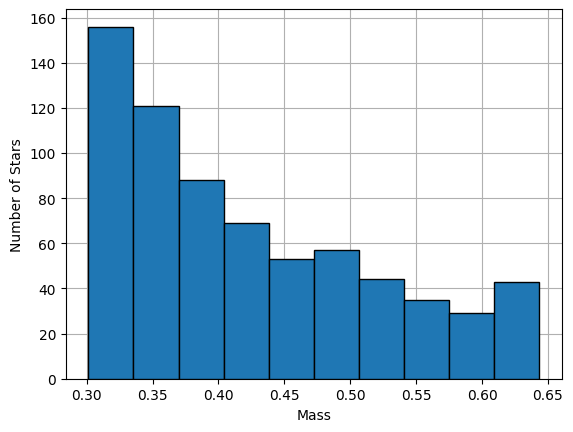

In [32]:
plt.grid(zorder=0)

plt.hist(df['Mass'],edgecolor='black',alpha=1,zorder=5)
plt.xlabel("Mass")
plt.ylabel("Number of Stars")


In [13]:
df = all_bright_mdwarfs
df['RA_numeric'] = Angle(df['RA_ICRS']).radian
df['DEC_numeric'] = Angle(df['DE_ICRS']).radian

# Convert ICRS coordinates
icrs_coords = SkyCoord(ra=df['RA_numeric'], dec=df['DEC_numeric'], unit='rad', frame='icrs')

# Aitoff projection plot
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')       
plt.grid(True)

# Plotting points on the Aitoff projection
plt.scatter(icrs_coords.ra.wrap_at(180 * u.deg).radian, icrs_coords.dec.radian, marker='o', color='blue')

# Show the plot
plt.title('Aitoff Projection Plot')
plt.show()      

UnitsError: No unit specified

In [78]:
list(all_bright_mdwarfs['SimbadName']).index('PM J00007-3510')

5

In [80]:
all_bright_mdwarfs['SimbadName'][-1000:]

7891    PM J21267+0344
7892    PM J21268-4448
7893    PM J21272-0650
7894    PM J21275+3401
7895    PM J21276+1933
             ...      
8886    PM J23590+2051
8887    PM J23596+0232
8888    PM J23596-7309
8889    PM J23597-4405
8890    PM J23598-3406
Name: SimbadName, Length: 1000, dtype: object

In [83]:
list(all_bright_mdwarfs['SimbadName']).index('PM J05085-1810')

2026

In [69]:
(all_bright_mdwarfs['plx'].values == '       ').sum()

7467

In [75]:
search_result = lightkurve.search_lightcurve('PM J08011+0315',mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 07,2019,SPOC,120,452844647,0.0
1,TESS Sector 07,2019,TESS-SPOC,1800,452844647,0.0
2,TESS Sector 34,2021,TESS-SPOC,600,452844647,0.0
3,TESS Sector 61,2023,TESS-SPOC,200,452844647,0.0
4,TESS Sector 07,2019,QLP,1800,452844647,0.0
5,TESS Sector 34,2021,QLP,600,452844647,0.0
6,TESS Sector 61,2023,QLP,200,452844647,0.0
7,TESS Sector 07,2019,GSFC-ELEANOR-LITE,1800,452844647,0.0
8,TESS Sector 07,2019,TGLC,1800,452844647,0.0


In [50]:
all_bright_mdwarfs['SimbadName']

2        PM J00001+6943
3       PM J00003-0802S
4        PM J00005-0533
5        PM J00006+1829
6        PM J00007+1624
             ...       
8886     PM J23590+2051
8887     PM J23596+0232
8888     PM J23596-7309
8889     PM J23597-4405
8890     PM J23598-3406
Name: SimbadName, Length: 8889, dtype: object

In [42]:
Kmags = np.array([float(i) for i in np.array(all_bright_mdwarfs['Kmag'])])
Jmags = np.array([float(i) for i in np.array(all_bright_mdwarfs['Jmag'])])
Hmags =np.array([float(i) for i in np.array(all_bright_mdwarfs['Hmag'])])

In [44]:
j_k = Jmags-Kmags
j_h = Jmags-Hmags
h_k = Hmags-Kmags

In [ ]:
plt.scatter(h_k,j_h,s=1)

(array([2.000e+00, 2.000e+00, 2.000e+01, 4.500e+01, 1.410e+02, 2.660e+02,
        5.740e+02, 1.251e+03, 2.446e+03, 4.142e+03]),
 array([2.96 , 3.591, 4.222, 4.853, 5.484, 6.115, 6.746, 7.377, 8.008,
        8.639, 9.27 ]),
 <BarContainer object of 10 artists>)

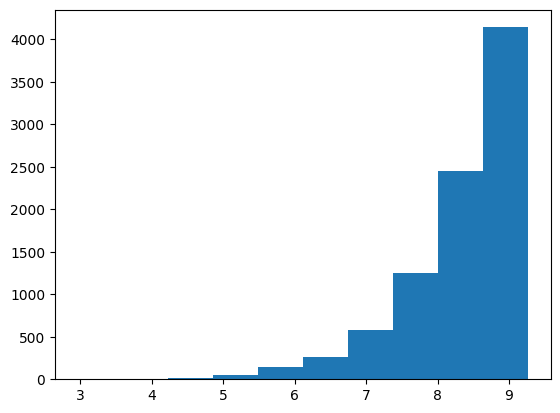

In [57]:
plt.hist(Kmags)

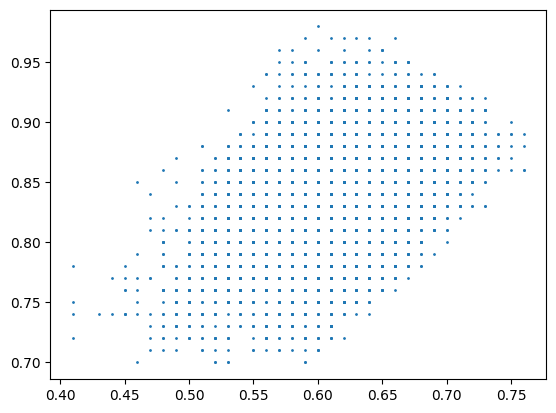

In [98]:
plt.scatter(j_h,j_k,s=1)